<a href="https://colab.research.google.com/github/mariabandeira/Reconhecimento-de-Digitos/blob/main/MiniProjeto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de Dígitos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# caminho dos arquivos CSV
file_train = 'https://raw.githubusercontent.com/mariabandeira/Reconhecimento-de-Digitos/main/dataset_digits/train.csv'
file_test = 'https://raw.githubusercontent.com/mariabandeira/Reconhecimento-de-Digitos/main/dataset_digits/test.csv'

# Lendo o CSV
X_train = pd.read_csv(file_train, sep=';')
X_test = pd.read_csv(file_test, sep=';')

# Exibindo as primeiras linhas dos DataFrames
print(X_train.head())
print(X_test.head())

In [ ]:
X_train.info()

In [ ]:
X_test.info()

In [ ]:
X_train.describe()

In [ ]:
X_test.describe()

In [ ]:
X_train['label'].value_counts()

# 3.1 Redução da dimensão das amostras

In [ ]:
# Intensidade da imagem

def intensidade(X):
  I = []
  for i in range(len(X)):
    sumpixel = X.iloc[i].sum() - X['label'][i]
    I.append(sumpixel / 255)
  return I

I_train = intensidade(X_train)
I_test = intensidade(X_test)

In [ ]:
# Simetria da Imagem: Sv + Sh

def simetria(X):
  # 1. Simetria Vertical
  Sv_list = []
  for img in range(len(X)):
    sumv = 0
    for i in range(28):
      for j in range(14):
        xi = i * 28 + j
        xj = i * 28 + (27 - j)
        sumv += abs(X.iloc[img, xi+1] - X.iloc[img, xj+1])
    Sv_list.append(sumv / 255)

  # 2. Simetria Horizontal
  Sh_list = []
  for img in range(len(X)):
    sumh = 0
    for j in range(28):
      for i in range(14):
        xi = i * 28 + j
        xj = (27 - i) * 28 + j
        sumh += abs(X.iloc[img, xi+1] - X.iloc[img, xj+1])
    Sh_list.append(sumh / 255)

  Si_list = [sv + sh for sv, sh in zip(Sv_list, Sh_list)]
  return Si_list

Si_train = simetria(X_train)
Si_test = simetria(X_test)

In [10]:
# o dataset train_redu irá conter apenas as colunas label, I_list e Si_list
train_redu = pd.DataFrame({'label': X_train['label'], 'intensidade': I_train, 'simetria': Si_train})
print(train_redu.head())

test_redu = pd.DataFrame({'label': X_test['label'], 'intensidade': I_test, 'simetria': Si_test})
print(test_redu.head())

   label  intensidade    simetria
0      0   145.435294  148.572549
1      0   118.576471  137.113725
2      0   127.600000  134.047059
3      0   138.047059  151.003922
4      0   146.215686  122.501961
   label  intensidade    simetria
0      0   147.933333  130.470588
1      0   131.054902  122.721569
2      0   134.890196  151.725490
3      0   139.976471  133.921569
4      0   129.580392  130.274510


In [11]:
train_redu.to_csv('dataset_redu/train_redu.csv', index=False, sep=';')
test_redu.to_csv('dataset_redu/test_redu.csv', index=False, sep=';')

# 3.2 Classificação dos dígitos 1x5

## Filtragem dos dados

In [12]:
train1x5 = train_redu[train_redu['label'].isin([1, 5])]
test1x5 = test_redu[test_redu['label'].isin([1, 5])]

In [13]:
print(train1x5['label'].value_counts())
print(test1x5['label'].value_counts())

label
1    608
5    576
Name: count, dtype: int64
label
1    292
5    291
Name: count, dtype: int64


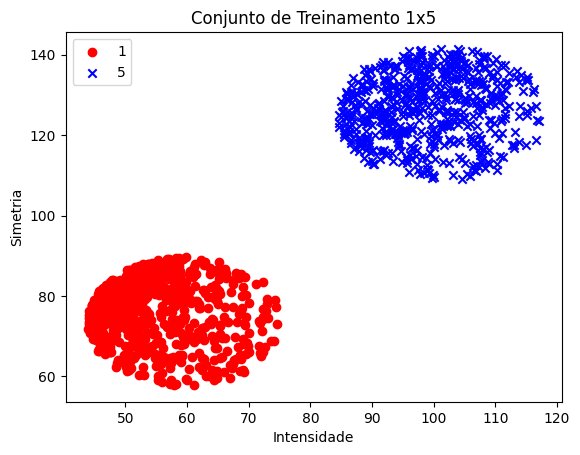

In [14]:
plt.scatter(train1x5[train1x5['label'] == 1]['intensidade'],
            train1x5[train1x5['label'] == 1]['simetria'],
            c='red', marker='o', label='1')  # Círculos azuis para a categoria 1

plt.scatter(train1x5[train1x5['label'] == 5]['intensidade'],
            train1x5[train1x5['label'] == 5]['simetria'],
            c='blue', marker='x', label='5')  # Triângulos vermelhos para a categoria 5

plt.title('Conjunto de Treinamento 1x5')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')

plt.legend()

plt.show()

In [15]:
train1x5.reset_index(drop=True, inplace=True)
train1x5.head()

,label,intensidade,simetria
0,1,44.701961,69.270588
1,1,59.850980,83.443137
2,1,48.552941,79.043137
3,1,69.435294,72.878431
4,1,51.541176,84.611765


In [16]:
test1x5.reset_index(drop=True, inplace=True)
test1x5.head()

,label,intensidade,simetria
0,1,51.639216,71.443137
1,1,51.674510,85.050980
2,1,44.847059,72.674510
3,1,50.760784,81.945098
4,1,57.788235,72.564706


In [17]:
X_train1x5 = train1x5[['intensidade', 'simetria']].values
y_train1x5 = np.array([1 if y_ == 1 else -1 for y_ in train1x5['label']])

In [18]:
X_test1x5 = test1x5[['intensidade', 'simetria']].values
y_test1x5 = np.array([1 if y_ == 1 else -1 for y_ in test1x5['label']]) # OBS: no pdf ele diz que o y é apenas o label

In [19]:
def pred_digito(y):
  y = np.where(y == 1, 1, 5)
  return y

## Regressão Linear

In [20]:
class LinearRegression:
  def __init__(self):
    self.w = None

  def fit(self, _X, _y):
    N = len(_X)

    X = np.column_stack((np.ones((N, 1)), _X))

    xtx = X.T @ X
    inv = np.linalg.inv(xtx) @ X.T
    self.w = inv @ _y

  def predict(self, _x):
    X = np.column_stack((np.ones((len(_x), 1)), _x))
    return [np.dot(self.w, xn) for xn in X]

  def getW(self):
    return self.w

In [21]:
class LRClassifier():
  def execute(self, _X, _y):
    lr = LinearRegression()
    lr.fit(_X, _y)
    self.w = lr.getW()

  def predict(self, X):
    N = len(X)
    X = np.column_stack((np.ones((N, 1)), X))
    return [np.sign(np.dot(self.w, xn)) for xn in X]

  def getRegressionY(self, regressionX, shift=0):
    return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]

### Treino

In [22]:
classifier = LRClassifier()
classifier.execute(X_train1x5, y_train1x5)

predictions = classifier.predict(X_train1x5)

In [23]:
# Predição do Dígito com LRClassifier
pred = np.array(predictions)
pred = pred_digito(pred)
pred

array([1, 1, 1, ..., 5, 5, 5])

In [24]:
lr = LinearRegression()
lr.fit(X_train1x5, y_train1x5)
y_pred = np.array(lr.predict(X_train1x5))
w = lr.getW()
print(w)

[ 3.58751288 -0.01875499 -0.02111635]


In [25]:
# Predição do Dígito com LinearRegression
y_pred = np.where(y_pred >= 0, 1, -1)
y_pred = pred_digito(y_pred)
y_pred

array([1, 1, 1, ..., 5, 5, 5])

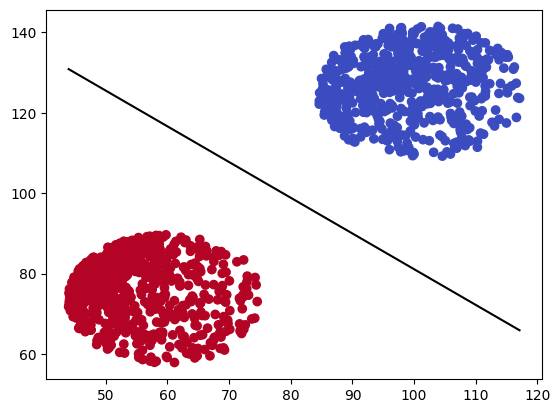

In [26]:
# Plotagem da Regressão Linear com LRClassifier
plt.scatter(X_train1x5[:, 0], X_train1x5[:, 1], c=y_train1x5, cmap='coolwarm')
x = np.linspace(X_train1x5[:, 0].min(), X_train1x5[:, 0].max(), 100)
y = classifier.getRegressionY(x)
plt.plot(x, y, color='black')
plt.show()

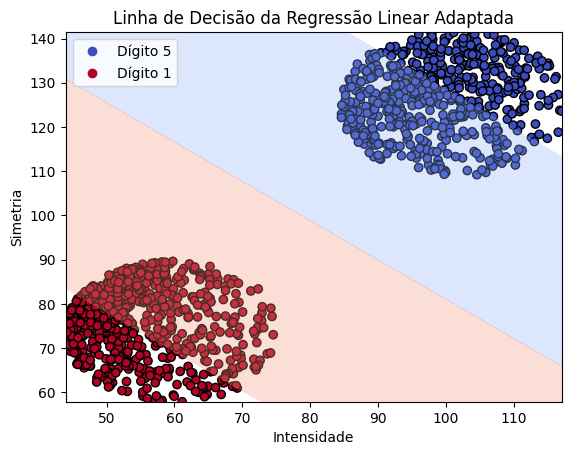

In [27]:
# Plotar os dados e a linha de decisão com LinearRegression
plt.figure()
scatter = plt.scatter(X_train1x5[:, 0], X_train1x5[:, 1], c=y_train1x5, cmap='coolwarm', marker='o', edgecolor='k')

xx, yy = np.meshgrid(np.linspace(X_train1x5[:, 0].min(), X_train1x5[:, 0].max(), 500),
                     np.linspace(X_train1x5[:, 1].min(), X_train1x5[:, 1].max(), 500))
Z = np.array(lr.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm', levels=[-1, 0, 1])
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Linha de Decisão da Regressão Linear Adaptada')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Dígito 5', 'Dígito 1'])
plt.show()


### Teste

In [28]:
predictions_test = classifier.predict(X_test1x5)
pred_test = np.array(predictions_test)
pred_test = pred_digito(pred_test)
pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5,

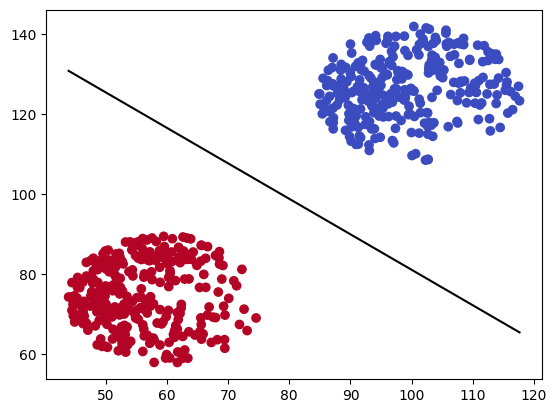

In [29]:
# Plotagem da Regressão Linear com LRClassifier
plt.scatter(X_test1x5[:, 0], X_test1x5[:, 1], c=y_test1x5, cmap='coolwarm')
x = np.linspace(X_test1x5[:, 0].min(), X_test1x5[:, 0].max(), 100)
y = classifier.getRegressionY(x)
plt.plot(x, y, color='black')
plt.show()

## Perceptron

In [30]:
class PocketPLA():
  def __init__(self):
    self.w = None

  def get_w(self):
    return self.w

  def set_w(self, w):
    self.w = w

  def execute(self, _X, y):
    X = np.array(_X)
    N = len(X)
    hasWrongClassifiedPoint = True
    bestError = len(y)

    self.w = np.zeros(len(X[0]))
    bestW = self.w
    for iter in range(N):

      #Testa se sign(wTXn) != Yn - ponto classificado errado
      for i in range(len(y)):
        if(np.sign(np.dot(self.w, X[i])) != y[i]):
          self.w = self.w + (y[i]*X[i])
          eIN = self.errorIN(X, y)
          if(bestError > eIN):
            bestError = eIN
            bestW = self.w
    self.w = bestW

  def getOriginalY(self, originalX):
    return (-self.w[0] - self.w[1]*originalX) / self.w[2]

  def h(self, x):
    return np.sign(np.dot(self.w, x))

  def errorIN(self, X, y):
    error = 0
    for i in range(len(y)):
      if(np.sign(np.dot(self.w, X[i])) != y[i]):
        error += 1

    return error

###  Treino

In [31]:
X_train1x5 = np.hstack((np.ones((len(X_train1x5), 1)), X_train1x5))

In [32]:
pla = PocketPLA()
pla.execute(X_train1x5, y_train1x5)

In [33]:
# Predição do Dígito com Pocket PLA
y_pla = []
for i in range(len(X_train1x5)):
  y_pla.append(pla.h(X_train1x5[i]))

y_pred_pla = pred_digito(np.array(y_pla))
y_pred_pla

array([1, 5, 1, ..., 5, 5, 5])

In [34]:
print('1: ', y_pla.count(1))
print('5: ', y_pla.count(-1))

1:  287
5:  897


In [35]:
xmin = X_train1x5[:,1].min()
xmax = X_train1x5[:,1].max()
print(xmin, xmax)

43.97254901960784 117.10196078431373


In [36]:
y_train1x5

array([ 1,  1,  1, ..., -1, -1, -1])

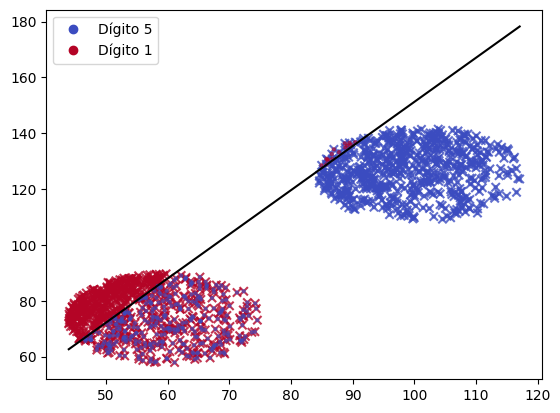

In [37]:
# Plotagem do resultado para o Pocket PLA
plt.scatter(X_train1x5[:, 1], X_train1x5[:, 2], c=y_train1x5, cmap='coolwarm', marker='x', alpha=0.8)
plt.scatter(X_train1x5[:, 1], X_train1x5[:, 2], c=np.array(y_pla), cmap='coolwarm', s=5, alpha=0.5)

x = np.linspace(xmin, xmax, 100)
y = pla.getOriginalY(x)
plt.plot(x, y, color='black')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Dígito 5', 'Dígito 1'])
plt.show()

In [38]:
pla.get_w()

array([ 938.        , -214.95686275,  135.97647059])

### Teste

In [39]:
X_test1x5 = np.hstack((np.ones((len(X_test1x5), 1)), X_test1x5))

In [40]:
# Predição do Dígito com Pocket PLA
pla_test = []
for i in range(len(X_test1x5)):
  pla_test.append(pla.h(X_test1x5[i]))

pred_pla_test = pred_digito(np.array(pla_test))
pred_pla_test

array([5, 1, 1, 1, 5, 5, 1, 1, 5, 1, 1, 5, 1, 5, 5, 5, 5, 5, 1, 5, 1, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5,
       1, 5, 5, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 5, 1, 5, 5, 5, 5, 1,
       5, 5, 5, 5, 1, 1, 1, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5,
       5, 1, 5, 5, 1, 5, 5, 5, 5, 1, 1, 5, 1, 1, 5, 5, 1, 5, 1, 5, 1, 1,
       1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 5, 5, 1, 1, 1, 5, 5, 5, 5, 5,
       1, 1, 1, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1,
       1, 1, 1, 1, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 1, 5, 1, 1, 1, 5, 1, 1,
       1, 5, 5, 5, 1, 5, 5, 1, 1, 5, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5,
       5, 5, 1, 5, 5, 5, 1, 5, 5, 5, 1, 1, 1, 1, 5, 1, 1, 5, 5, 5, 5, 1,
       1, 1, 5, 5, 5, 5, 1, 5, 5, 1, 5, 1, 5, 5, 1, 5, 1, 5, 5, 1, 5, 5,
       5, 1, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 1, 5, 5, 1, 5, 1, 1, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 1, 5, 1,
       1, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [41]:
xmin_test = X_test1x5[:,1].min()
xmax_test = X_test1x5[:,1].max()
print(xmin_test, xmax_test)

43.92549019607843 117.63921568627451


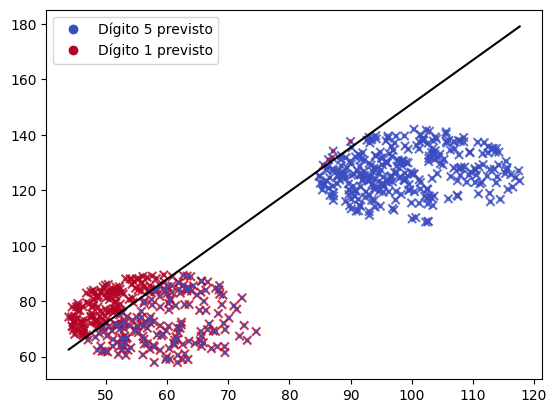

In [42]:
# Plotagem do resultado para o Pocket PLA
plt.scatter(X_test1x5[:, 1], X_test1x5[:, 2], c=y_test1x5, cmap='coolwarm', marker='x', alpha=0.8)
plt.scatter(X_test1x5[:, 1], X_test1x5[:, 2], c=np.array(pla_test), cmap='coolwarm', s=5, alpha=0.6)
x = np.linspace(xmin_test, xmax_test, 100)
y = pla.getOriginalY(x)
plt.plot(x, y, color='black')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Dígito 5 previsto', 'Dígito 1 previsto'])
plt.show()

### Métricas de Aprendizado

In [43]:
#Computando o erro dentro da amostra (Ein)
N_in = len(y_train1x5)
eIn = 0
for i in range(N_in):
    if(y_pla[i] != y_train1x5[i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))

#Computando o erro dentro da amostra (Eout)
N_out = len(y_test1x5)
eOut = 0
for i in range(N_out):
    if(pla_test[i] != y_test1x5[i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

Ein = 0.2964527027027027
Eout = 0.30874785591766724


In [44]:
print(classification_report(y_train1x5.tolist(), y_pla))

              precision    recall  f1-score   support

          -1       0.63      0.97      0.76       576
           1       0.95      0.45      0.61       608

    accuracy                           0.70      1184
   macro avg       0.79      0.71      0.68      1184
weighted avg       0.79      0.70      0.68      1184



## Regressão Logística

In [45]:
import numpy as np
from numpy import linalg as LA
import random
from random import sample

class LogisticRegression_:
  def __init__(self, eta=0.1, tmax=1000, bs=1000000):
    self.eta = eta
    self.tmax = tmax
    self.batch_size = bs

  # Infere o vetor w da funçao hipotese
  #Executa a minimizao do erro de entropia cruzada pelo algoritmo gradiente de descida
  def fit(self, _X, _y):
    X = np.array(_X)
    y = np.array(_y)

    N = X.shape[0]
    d = X.shape[1]
    self.w = np.zeros(d)

    for t in range(self.tmax):
      #grad_t = -1 / N * np.sum((_y @ _X) / (1 + np.exp(_y @ w @ t @ _X)))
      grad_t = (1 / N) * X.T.dot(self.predict_prob(X) - y)

      if LA.norm(grad_t) < 1e-3:
        break

      self.w -= self.eta * grad_t

    self.w = w

  #funcao hipotese inferida pela regressa logistica
  def predict_prob(self, X):
    s = np.dot(X, self.w)
    prob = np.exp(s) / (1 + np.exp(s))
    return prob

  #Predicao por classificação linear
  def predict(self, X):
    prob = self.predict_prob(X)
    y = np.where(prob >= 0.5, 1, -1)
    return y

  def getW(self):
    return self.w

  def getRegressionY(self, regressionX, shift=0):
    return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]

### Treino

In [46]:
LR = LogisticRegression_()
LR.fit(X_train1x5, y_train1x5)
pred_logistic = LR.predict_prob(X_train1x5)
pred_logistic

array([0.78353483, 0.66885115, 0.73258941, ..., 0.21449646, 0.25632801,
       0.21499347])

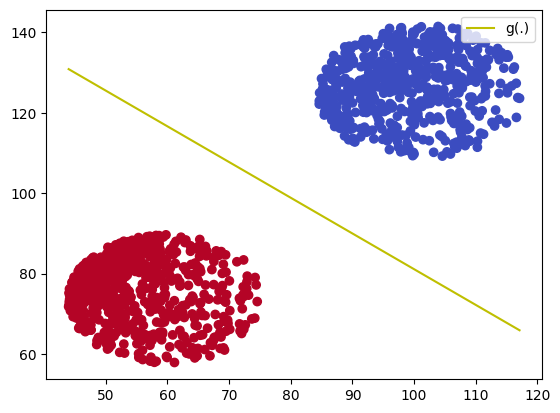

In [47]:
#desenha a reta inferida pela regressao logistica
xRL = [xmin, xmax]
yRL = [classifier.getRegressionY(xRL[0]), classifier.getRegressionY(xRL[1])]
plt.scatter(X_train1x5[:, 1], X_train1x5[:, 2], c=y_train1x5, cmap='coolwarm')
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')
plt.show()

### Teste

In [48]:
pred_logistic_test = LR.predict_prob(X_test1x5)
pred_logistic_test

array([0.75220393, 0.69474374, 0.77061483, 0.71199914, 0.72539708,
       0.75307622, 0.6741634 , 0.65778226, 0.795855  , 0.76984295,
       0.7099514 , 0.69171771, 0.73738859, 0.74757777, 0.76839009,
       0.72469063, 0.71702578, 0.70378803, 0.6716955 , 0.64589417,
       0.72734994, 0.73574179, 0.76393065, 0.77325302, 0.64569076,
       0.65516072, 0.7539465 , 0.65366258, 0.73464845, 0.78289509,
       0.65361826, 0.63614889, 0.68677246, 0.74155609, 0.75406069,
       0.74967347, 0.68363494, 0.7367865 , 0.72836826, 0.71326042,
       0.7809183 , 0.69372218, 0.72824545, 0.66204699, 0.71676348,
       0.64519113, 0.76302231, 0.74606513, 0.78286586, 0.77850211,
       0.70617532, 0.7640489 , 0.71788842, 0.73317778, 0.69845234,
       0.75552853, 0.73629021, 0.78230985, 0.7311713 , 0.76298274,
       0.67852227, 0.75144976, 0.6811552 , 0.78219451, 0.73668361,
       0.74195416, 0.73551741, 0.71107044, 0.70012508, 0.76397827,
       0.64185194, 0.73613086, 0.75812347, 0.68095697, 0.72856

In [49]:
digits_logistic_test = pred_digito(LR.predict(X_test1x5))

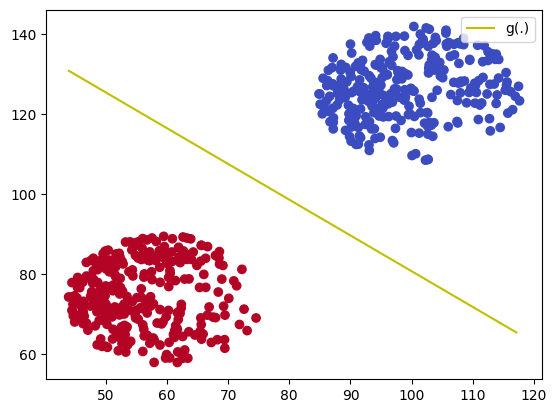

In [50]:
#desenha a reta inferida pela regressao logistica
yRL = [classifier.getRegressionY(xmin_test), classifier.getRegressionY(xmax_test)]
plt.scatter(X_test1x5[:, 1], X_test1x5[:, 2], c=y_test1x5, cmap='coolwarm')
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# 3.3. Classificador de dígitos completo

In [51]:
X_train0 = train_redu[['intensidade', 'simetria']].values
y_train0 = np.array([1 if y_ == 0 else -1 for y_ in train_redu['label']])

In [52]:
X_test0 = test_redu[['intensidade', 'simetria']].values
y_test0 = np.array([1 if y_ == 0 else -1 for y_ in test_redu['label']])

## Regressão Linear

In [53]:
classifier0 = LRClassifier()
classifier0.execute(X_train0, y_train0)
predictions = classifier0.predict(X_train0)

In [54]:
lr0 = LinearRegression()
lr0.fit(X_train0, y_train0)
y_pred = np.array(lr0.predict(X_train0))
w = lr0.getW()
print(w)

[-2.23739689  0.0254455  -0.0066963 ]


In [55]:
y_pred = np.where(y_pred >= 0, 1, -1)
y_pred

array([ 1, -1,  1, ..., -1, -1, -1])

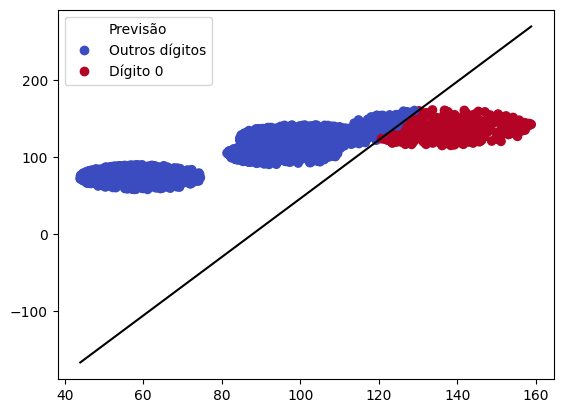

In [56]:
# Plotagem da Regressão Linear com LRClassifier
plt.scatter(X_train0[:, 0], X_train0[:, 1], c=y_pred, cmap='coolwarm')
x = np.linspace(X_train0[:, 0].min(), X_train0[:, 0].max(), 100)
y = classifier0.getRegressionY(x)
plt.plot(x, y, color='black')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Outros dígitos', 'Dígito 0'], title='Previsão')
plt.show()

In [57]:
y_pred.tolist().count(1)

322

In [58]:
len(y_pred)

2186

In [59]:
1744+322

2066

In [60]:
# remover de train_redu os dados que não tem y_pred = -1
indices_to_keep = []
for i in range(len(train_redu)):
  if(y_pred[i] == -1):
    indices_to_keep.append(i)

train_redu_0 = train_redu.iloc[indices_to_keep]

len(train_redu_0)

1864

In [61]:
X_train1 = train_redu_0[['intensidade', 'simetria']].values
y_train1 = np.array([1 if y_ == 1 else -1 for y_ in train_redu_0['label']])

In [62]:
classifier1 = LRClassifier()
classifier1.execute(X_train1, y_train1)
predictions = classifier1.predict(X_train1)

lr1 = LinearRegression()
lr1.fit(X_train1, y_train1)
y_pred1 = np.array(lr1.predict(X_train1))
w = lr1.getW()
print(w)

[ 3.13153492 -0.03004819 -0.00898044]


In [63]:
y_pred1 = np.where(y_pred1 >= 0, 1, -1)
y_pred1

array([-1, -1, -1, ..., -1, -1, -1])

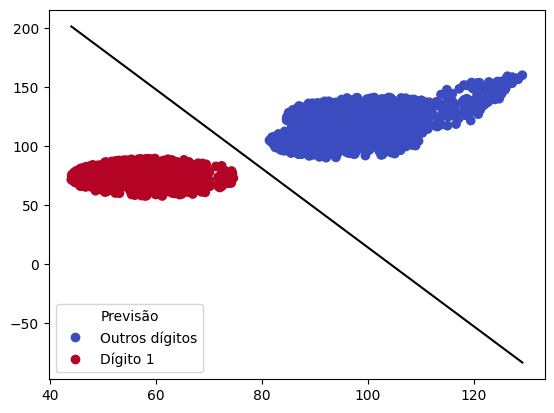

In [64]:
# Plotagem da Regressão Linear com LRClassifier
plt.scatter(X_train1[:, 0], X_train1[:, 1], c=y_pred1, cmap='coolwarm')
x = np.linspace(X_train1[:, 0].min(), X_train1[:, 0].max(), 100)
y = classifier1.getRegressionY(x)
plt.plot(x, y, color='black')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Outros dígitos', 'Dígito 1'], title='Previsão')
plt.show()

In [65]:
# remover de train_redu os dados que não tem y_pred = -1
indices_to_keep = []
for i in range(len(train_redu_0)):
  if(y_pred1[i] == -1):
    indices_to_keep.append(i)

train_redu_1 = train_redu_0.iloc[indices_to_keep]

len(train_redu_1)

1256

In [66]:
X_train4 = train_redu_1[['intensidade', 'simetria']].values
y_train4 = np.array([1 if y_ == 4 else -1 for y_ in train_redu_1['label']])

In [67]:
classifier4 = LRClassifier()
classifier4.execute(X_train4, y_train4)
predictions = classifier4.predict(X_train4)

lr4 = LinearRegression()
lr4.fit(X_train4, y_train4)
y_pred4 = np.array(lr4.predict(X_train4))
w = lr4.getW()
print(w)

[ 6.07307683e+00  6.06019786e-03 -5.70824398e-02]


In [68]:
y_pred4 = np.where(y_pred4 >= 0, 1, -1)
y_pred4

array([-1, -1, -1, ..., -1, -1, -1])

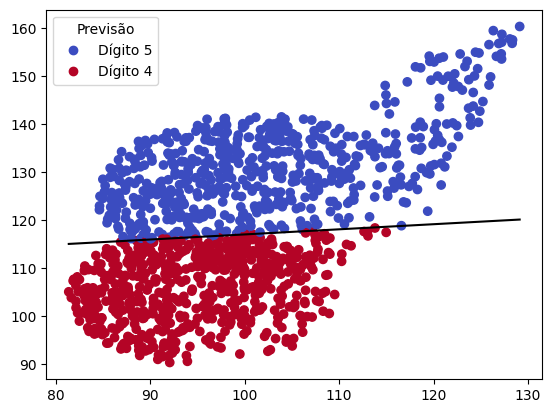

In [69]:
# Plotagem da Regressão Linear com LRClassifier
plt.scatter(X_train4[:, 0], X_train4[:, 1], c=y_pred4, cmap='coolwarm')
x = np.linspace(X_train4[:, 0].min(), X_train4[:, 0].max(), 100)
y = classifier4.getRegressionY(x)
plt.plot(x, y, color='black')
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Dígito 5', 'Dígito 4'], title='Previsão')
plt.show()

In [70]:
def f0(x, model='lr'):
  if model == 'PLA':
    pred = pla0.h(x)
  else:
    pred = classifier0.predict(x)
  return np.array(pred)

def f1(x, model='lr'):
  if model == 'PLA':
    pred = pla1.h(x)
  else:
    pred = classifier1.predict(x)
  return np.array(pred)

def f4(x, model='lr'):
  if model == 'PLA':
    pred = pla4.h(x)
  else:
    pred = classifier4.predict(x)
  return np.array(pred)

def classificar_digito(x, model='lr'):
  if f0(x, model) == 1:
    return 0
  elif f1(x, model) == 1:
    return 1
  elif f4(x, model) == 1:
    return 4
  else:
    return 5

imagem_teste = train_redu.head(1)[['intensidade', 'simetria']].values
digito_classificado = classificar_digito(imagem_teste)
print(f"O dígito classificado é: {digito_classificado}")

O dígito classificado é: 0


In [71]:
img = np.array(f0(train_redu.head(1)[['intensidade', 'simetria']].values))
img == 1

array([ True])

In [72]:
classifier0.predict(train_redu[['intensidade', 'simetria']].values)

[1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,


In [73]:
digito_classificado = []
for i in range(len(train_redu)):
  imagem_teste = train_redu.iloc[i][['intensidade', 'simetria']].values.reshape(1, -1)
  digito_classificado.append(classificar_digito(imagem_teste))
print(digito_classificado)

[0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 5, 0, 0, 0, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 5, 5, 5, 0, 5, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 5, 5, 5, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 5, 5, 0, 5, 5, 0, 0, 0, 5, 0, 5, 5, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0, 

In [74]:
digito_classificado_teste = []
for i in range(len(test_redu)):
  imagem_teste = test_redu.iloc[i][['intensidade', 'simetria']].values.reshape(1, -1)
  digito_classificado_teste.append(classificar_digito(imagem_teste))
print(digito_classificado_teste)

[0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 5, 0, 5, 5, 0, 5, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

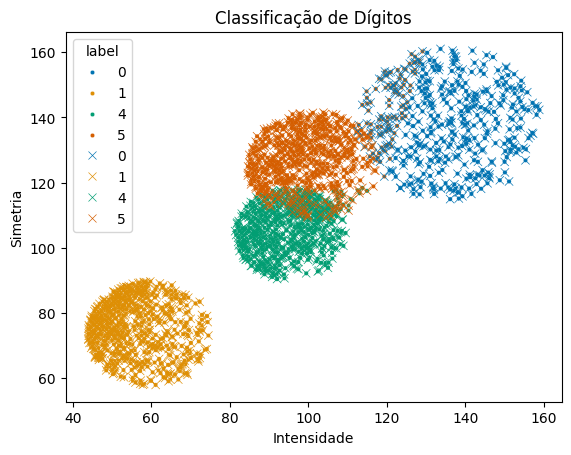

In [75]:
sns.scatterplot(x='intensidade', y='simetria', hue=digito_classificado, data=train_redu, palette='colorblind', s=10)
sns.scatterplot(x='intensidade', y='simetria', hue=train_redu['label'], data=train_redu, palette='colorblind', marker='x')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Classificação de Dígitos')
plt.show()

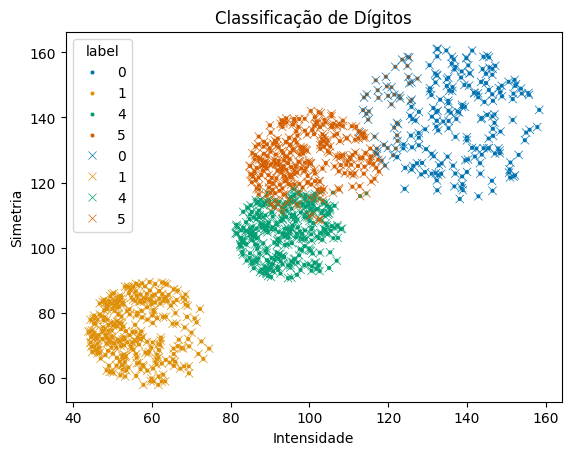

In [76]:
sns.scatterplot(x='intensidade', y='simetria', hue=digito_classificado_teste, data=test_redu, palette='colorblind', s=10)
sns.scatterplot(x='intensidade', y='simetria', hue=test_redu['label'], data=test_redu, palette='colorblind', marker='x')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Classificação de Dígitos')
plt.show()

In [77]:
#Computando o erro dentro da amostra (Ein)
N_in = len(train_redu)
eIn = 0
for i in range(N_in):
    if(digito_classificado[i] != train_redu['label'][i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))

Ein = 0.08920402561756634


In [78]:
#Computando o erro dentro da amostra (Eout)
N_out = len(test_redu)
eOut = 0
for i in range(N_out):
    if(digito_classificado_teste[i] != test_redu['label'][i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

Eout = 0.06726457399103139


In [79]:
print(classification_report(train_redu['label'].tolist(), digito_classificado))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       425
           1       1.00      1.00      1.00       608
           4       0.88      0.97      0.92       577
           5       0.81      0.87      0.84       576

    accuracy                           0.91      2186
   macro avg       0.92      0.90      0.91      2186
weighted avg       0.92      0.91      0.91      2186



In [80]:
print(classification_report(test_redu['label'].tolist(), digito_classificado_teste))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.92      0.99      0.95       314
           5       0.85      0.91      0.88       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



## Perceptron

In [81]:
X_train0_pla = np.hstack((np.ones((len(X_train0), 1)), X_train0))

In [82]:
X_test0_pla = np.hstack((np.ones((len(X_test0), 1)), X_test0))

In [83]:
pla0 = PocketPLA()
pla0.execute(X_train0_pla, y_train0)

In [ ]:
# Predição do Dígito com Pocket PLA
y_pla0 = []
for i in range(len(X_train0_pla)):
  y_pla0.append(pla0.h(X_train0_pla[i]))

In [85]:
xmin = X_train0_pla[:,1].min()
xmax = X_train0_pla[:,1].max()

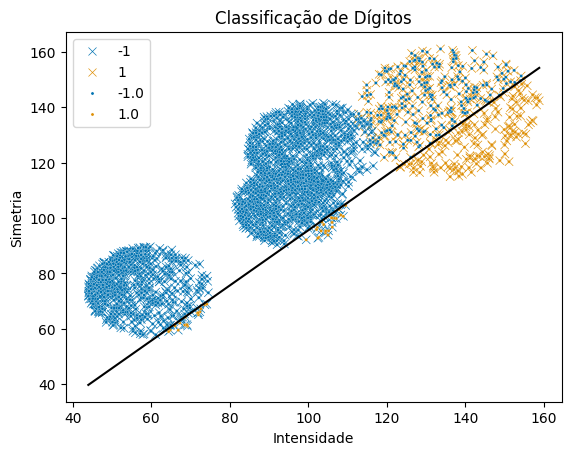

In [86]:
sns.scatterplot(x='intensidade', y='simetria', hue=y_train0, data=train_redu, palette='colorblind', marker='x')
sns.scatterplot(x='intensidade', y='simetria', hue=y_pla0, data=train_redu, palette='colorblind', s=5)
x = np.linspace(xmin, xmax, 100)
y = pla0.getOriginalY(x)
plt.plot(x, y, color='black')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Classificação de Dígitos')
plt.show()

In [87]:
def new_data(X, y_pred):
  indices_to_keep = []
  for i in range(len(X)):
    if(y_pred[i] == -1):
      indices_to_keep.append(i)
  return X.iloc[indices_to_keep]

In [88]:
train_redu_0_pla = new_data(train_redu, y_pred_pla)
train_redu_0_pla

IndexError: index 1184 is out of bounds for axis 0 with size 1184

In [ ]:
X_train1_pla = train_redu_0_pla[['intensidade', 'simetria']].values
y_train1_pla = np.array([1 if y_ == 1 else -1 for y_ in train_redu_0_pla['label']])

In [ ]:
X_train1_pla = np.hstack((np.ones((len(X_train1_pla), 1)), X_train1_pla))

In [ ]:
pla1 = PocketPLA()
pla1.execute(X_train1_pla, y_train1_pla)

In [ ]:
y_pla1 = []
for i in range(len(X_train1_pla)):
  y_pla1.append(pla1.h(X_train1_pla[i]))

In [ ]:
xmin = X_train1_pla[:,1].min()
xmax = X_train1_pla[:,1].max()

In [ ]:
sns.scatterplot(x='intensidade', y='simetria', hue=y_train1_pla, data=train_redu_0_pla, palette='colorblind', marker='x')
sns.scatterplot(x='intensidade', y='simetria', hue=y_pla1, data=train_redu_0_pla, palette='colorblind', s=5)
x = np.linspace(xmin, xmax, 100)
y = pla1.getOriginalY(x)
plt.plot(x, y, color='black')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Classificação de Dígitos')
plt.show()

In [ ]:
train_redu_1_pla = new_data(train_redu_0_pla, y_pla1)

In [ ]:
X_train4_pla = train_redu_1_pla[['intensidade', 'simetria']].values
y_train4_pla = np.array([1 if y_ == 4 else -1 for y_ in train_redu_1_pla['label']])

In [ ]:
X_train4_pla = np.hstack((np.ones((len(X_train4_pla), 1)), X_train4_pla))

In [ ]:
pla4 = PocketPLA()
pla4.execute(X_train4_pla, y_train4_pla)

In [ ]:
y_pla4 = []
for i in range(len(X_train4_pla)):
  y_pla4.append(pla4.h(X_train4_pla[i]))

In [ ]:
xmin = X_train4_pla[:,1].min()
xmax = X_train4_pla[:,1].max()

In [ ]:
sns.scatterplot(x='intensidade', y='simetria', hue=y_train4_pla, data=train_redu_1_pla, palette='colorblind', marker='x')
sns.scatterplot(x='intensidade', y='simetria', hue=y_pla4, data=train_redu_1_pla, palette='colorblind', s=5)
x = np.linspace(xmin, xmax, 100)
y = pla4.getOriginalY(x)
plt.plot(x, y, color='black')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.show()

In [ ]:
digito_classificado_pla = []
for i in range(len(X_train0_pla)):
  imagem_teste = X_train0_pla[i]
  digito_classificado_pla.append(classificar_digito(imagem_teste, model='PLA'))
print(digito_classificado_pla)

In [ ]:
sns.scatterplot(x='intensidade', y='simetria', hue=train_redu['label'], data=train_redu, palette='colorblind', marker='x')
sns.scatterplot(x='intensidade', y='simetria', hue=digito_classificado_pla, data=train_redu, palette='colorblind', s=10)
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Classificação de Dígitos')
plt.show()

In [ ]:
digito_classificado_teste_pla = []
for i in range(len(X_test0_pla)):
  imagem_teste = X_test0_pla[i]
  digito_classificado_teste_pla.append(classificar_digito(imagem_teste, model='PLA'))

In [ ]:
sns.scatterplot(x='intensidade', y='simetria', hue=test_redu['label'], data=test_redu, palette='colorblind', marker='x')
sns.scatterplot(x='intensidade', y='simetria', hue=digito_classificado_teste_pla, data=test_redu, palette='colorblind', s=10)
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Classificação de Dígitos')
plt.show()

In [ ]:
#Computando o erro dentro da amostra (Ein)
N_in = len(train_redu)
eIn = 0
for i in range(N_in):
    if(digito_classificado_pla[i] != train_redu['label'][i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))

#Computando o erro dentro da amostra (Eout)
N_out = len(test_redu)
eOut = 0
for i in range(N_out):
    if(digito_classificado_teste_pla[i] != test_redu['label'][i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

In [ ]:
print(classification_report(train_redu['label'].tolist(), digito_classificado_pla))

In [ ]:
print(classification_report(test_redu['label'].tolist(), digito_classificado_teste_pla))

## Regressão Logística